In [2]:
import numpy as np
import os
import glob
import json
import matplotlib.pyplot as plt

In [3]:
def get_result_files(results_dir, dncbtd):
    """
    Returns paths to results associated with each real dataset.

    results_dir (str): filepath to results directory
    dncbtd (Bool): Set to True if model is DNCB-TD
    """
    ## Get paths to result files
    directory_path = results_dir
    files = glob.glob(os.path.join(directory_path, '*.npz'))

    dimension_to_files = {}
    for file_path in files:
        # Load the NPZ file
        data = np.load(file_path)
        # Get data dimensions
        if dncbtd:
            i = data['Theta_IC'].shape[0]
            j = data['Phi_KJ'].shape[1]
        else:
            i = data['A_IK'].shape[0]
            j = data['H_KJ'].shape[1]
        data_dimensions = (i,j)
        
        if data_dimensions in dimension_to_files:
            dimension_to_files[data_dimensions].append(file_path)
        else:
            dimension_to_files[data_dimensions] = [file_path]
        del data
    bisulfite_dimension = (188,5000)  # Change this to the dimension you want to look up
    array_dimension = (400,5000) 
    olivetti_dimension = (400,4096)
    bisulfite_files = dimension_to_files[bisulfite_dimension]
    array_files = dimension_to_files[array_dimension]
    olivetti_files = dimension_to_files[olivetti_dimension]

    return bisulfite_files, array_files, olivetti_files

def process_results_dncbtd(files):
    """
    For a given dataset, returns 2 arrays indexed by C and K:
    1) best heldout PPD
    2) standard deviations across all masks/random initializations
    """
    dimension_dict = {}

    for file_path in files:
        # Load the NPZ file
        data = np.load(file_path)

        # Get the dimensions
        c = data['Theta_IC'].shape[1]
        k = data['Phi_KJ'].shape[0]

        # Create a tuple (c, k) to use as the key
        dimension_key = (c, k)

        # Append the file path to the list for that dimension or create a new list
        if dimension_key in dimension_dict:
            dimension_dict[dimension_key].append(file_path)
        else:
            dimension_dict[dimension_key] = [file_path]
    dncbtd_results = np.zeros((4, 6))
    dncbtd_std = np.zeros((4, 6))
    c = [4, 6, 8, 10]
    k = [4, 8, 10, 14, 20, 30]
    for i in range(4):
        for j in range(6):
            if c[i] > k[j]:
                continue
            else:
                specific_dimension = (c[i], k[j])  # Change this to the dimension you want to look up
                matching_files = dimension_dict[specific_dimension]
                ppds = []
                for file in matching_files:
                    ppds.append(np.load(file)['heldout_ppd'])
                dncbtd_results[i][j] = max(ppds)
                dncbtd_std[i][j] = np.std(ppds)
    return dncbtd_results, dncbtd_std

def process_results(files, model):
    """
    For a given dataset, returns 2 arrays indexed by K:
    1) best heldout PPD
    2) standard deviations across all masks/random initializations

    model (str): {dncbmf, bgnmf}
    """
    dimension_dict = {}

    for file_path in files:
        # Load the NPZ file
        data = np.load(file_path)

        # Get the dimensions
        k = data['A_IK'].shape[1]

        dimension_key = k

        # Append the file path to the list for that dimension or create a new list
        if dimension_key in dimension_dict:
            dimension_dict[dimension_key].append(file_path)
        else:
            dimension_dict[dimension_key] = [file_path]
    model_results = []
    model_std = []
    for k in [4, 8, 10, 14, 20, 30]:
        specific_dimension = k  # Change this to the dimension you want to look up
        matching_files = dimension_dict[specific_dimension]
        ppds = []
        for file in matching_files:
            if model == 'dncbmf':
                ppds.append(np.load(file)['heldout_ppd'])
            elif model == 'bgnmf':
                ppds.append(np.load(file)['ppd'])
        model_results.append(max(ppds))
        model_std.append(np.std(ppds))
    return model_results, model_std

In [4]:
dncbtd_files_bisulfite, dncbtd_files_array, dncbtd_files_olivetti = get_result_files('/home/gnagulpally/dncb-refactor/results/heldout_experiment', dncbtd = True)
dncbtd_results_bisulfite, dncbtd_std_bisulfite = process_results_dncbtd(dncbtd_files_bisulfite)
dncbtd_results_array, dncbtd_std_array = process_results_dncbtd(dncbtd_files_array)
dncbtd_results_olivetti, dncbtd_std_olivetti = process_results_dncbtd(dncbtd_files_olivetti)

In [5]:
dncbmf_files_bisulfite, dncbmf_files_array, dncbmf_files_olivetti = get_result_files('/home/gnagulpally/dncb-refactor/results/heldout_experiment_prbgnmf', dncbtd = False)
dncbmf_results_bisulfite, dncbmf_std_bisulfite = process_results(dncbmf_files_bisulfite, model = 'dncbmf')
dncbmf_results_array, dncbmf_std_array = process_results(dncbmf_files_array, model = 'dncbmf')
dncbmf_results_olivetti, dncbmf_std_olivetti = process_results(dncbmf_files_olivetti, model = 'dncbmf')

In [6]:
bgnmf_files_bisulfite, bgnmf_files_array, bgnmf_files_olivetti = get_result_files('/home/gnagulpally/dncb-refactor/results/heldout_experiment_bgnmf', dncbtd = False)
bgnmf_results_bisulfite, bgnmf_std_bisulfite = process_results(bgnmf_files_bisulfite, model = 'bgnmf')
bgnmf_results_array, bgnmf_std_array = process_results(bgnmf_files_array, model = 'bgnmf')
bgnmf_results_olivetti, bgnmf_std_olivetti = process_results(bgnmf_files_olivetti, model = 'bgnmf')

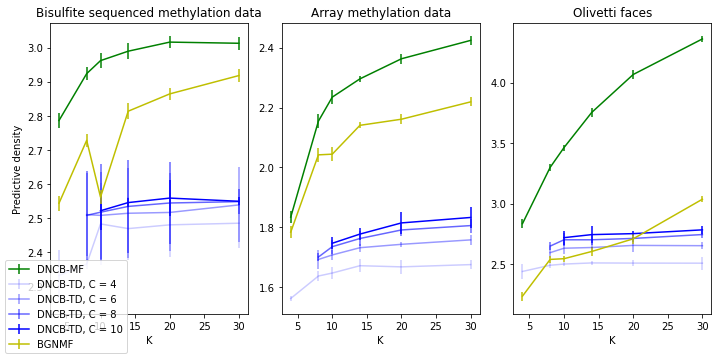

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))
ax1.errorbar([4, 8, 10, 14, 20, 30], dncbmf_results_bisulfite, yerr = [i*2 for i in dncbmf_std_bisulfite], color = 'g', label = 'DNCB-MF')
ax1.errorbar([4, 8, 10, 14, 20, 30], dncbtd_results_bisulfite[0], yerr = 2*dncbtd_std_bisulfite[0], color = 'b', alpha = 0.2, label = 'DNCB-TD, C = 4')
ax1.errorbar([8, 10, 14, 20, 30], dncbtd_results_bisulfite[1][1:], yerr = 2*dncbtd_std_bisulfite[1][1:], color = 'b', alpha = 0.4, label = 'DNCB-TD, C = 6')
ax1.errorbar([8, 10, 14, 20, 30], dncbtd_results_bisulfite[2][1:], yerr = 2*dncbtd_std_bisulfite[2][1:], color = 'b', alpha = 0.6, label = 'DNCB-TD, C = 8')
ax1.errorbar([10, 14, 20, 30], dncbtd_results_bisulfite[3][2:], yerr = 2*dncbtd_std_bisulfite[3][2:], color = 'b', label = 'DNCB-TD, C = 10')
ax1.errorbar([4, 8, 10, 14, 20, 30], bgnmf_results_bisulfite, yerr = [i*2 for i in dncbmf_std_bisulfite], color = 'y', label = 'BGNMF')
ax1.set_title('Bisulfite sequenced methylation data')
ax1.set_xlabel('K')
ax1.set_ylabel('Predictive density')
ax2.errorbar([4, 8, 10, 14, 20, 30], dncbmf_results_array, yerr = [i*2 for i in dncbmf_std_array], color = 'g', label = 'DNCB-MF')
ax2.errorbar([4, 8, 10, 14, 20, 30], dncbtd_results_array[0], yerr = 2*dncbtd_std_array[0], color = 'b', alpha = 0.2, label = 'DNCB-TD, C = 4')
ax2.errorbar([8, 10, 14, 20, 30], dncbtd_results_array[1][1:], yerr = 2*dncbtd_std_array[1][1:], color = 'b', alpha = 0.4, label = 'DNCB-TD, C = 6')
ax2.errorbar([8, 10, 14, 20, 30], dncbtd_results_array[2][1:], yerr = 2*dncbtd_std_array[2][1:], color = 'b', alpha = 0.6, label = 'DNCB-TD, C = 8')
ax2.errorbar([10, 14, 20, 30], dncbtd_results_array[3][2:], yerr = 2*dncbtd_std_array[3][2:], color = 'b', label = 'DNCB-TD, C = 10')
ax2.errorbar([4, 8, 10, 14, 20, 30], bgnmf_results_array, yerr = [i*2 for i in dncbmf_std_array], color = 'y', label = 'BGNMF')
ax2.set_title('Array methylation data')
ax2.set_xlabel('K')

ax3.errorbar([4, 8, 10, 14, 20, 30], dncbmf_results_olivetti, yerr = [i*2 for i in dncbmf_std_olivetti], color = 'g', label = 'DNCB-MF')
ax3.errorbar([4, 8, 10, 14, 20, 30], dncbtd_results_olivetti[0], yerr = 2*dncbtd_std_olivetti[0], color = 'b', alpha = 0.2, label = 'DNCB-TD, C = 4')
ax3.errorbar([8, 10, 14, 20, 30], dncbtd_results_olivetti[1][1:], yerr = 2*dncbtd_std_olivetti[1][1:], color = 'b', alpha = 0.4, label = 'DNCB-TD, C = 6')
ax3.errorbar([8, 10, 14, 20, 30], dncbtd_results_olivetti[2][1:], yerr = 2*dncbtd_std_olivetti[2][1:], color = 'b', alpha = 0.6, label = 'DNCB-TD, C = 8')
ax3.errorbar([10, 14, 20, 30], dncbtd_results_olivetti[3][2:], yerr = 2*dncbtd_std_olivetti[3][2:], color = 'b', label = 'DNCB-TD, C = 10')
ax3.errorbar([4, 8, 10, 14, 20, 30], bgnmf_results_olivetti, yerr = [i*2 for i in dncbmf_std_olivetti], color = 'y', label = 'BGNMF')
ax3.set_title('Olivetti faces')
ax3.set_xlabel('K')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')
plt.tight_layout()
plt.savefig('figures/heldout_figure.pdf')